In [ ]:
## resource

# A3C
# https://blog.tensorflow.org/2018/07/deep-reinforcement-learning-keras-eager-execution.html
# https://github.com/tensorflow/models/blob/master/research/a3c_blogpost/a3c_cartpole.py

# thread
# https://realpython.com/intro-to-python-threading/
# https://stackoverflow.com/questions/59633435/threading-in-jupyter-notebook

# env.render() in colab
# https://stackoverflow.com/questions/50107530/how-to-render-openai-gym-in-google-colab

In [ ]:
## setup

import gym
import numpy as np

# env.render
# !apt-get install -y xvfb python-opengl > /dev/null 2>&1
# !pip install gym pyvirtualdisplay > /dev/null 2>&1
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

# FIFO queue
from queue import Queue
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import layers
import os
import threading
import multiprocessing
import time
import argparse

# evaluation video
import imageio
# import base64
# import IPython

In [ ]:
## hyperparameter

ENV = 'CartPole-v0'
SAVE_DIR = '/tmp'
VIDEO_DIR_01 = '/tmp/video_random.mp4'
VIDEO_DIR_02 = '/tmp/vdieo_a3c.mp4'

plt.style.use('default')

In [ ]:
## test threading

def myfunc(name):
    print(f'myfunc started with {name}')
    time.sleep(2)
    print('myfunc ended')

print('main started')
t = threading.Thread(target = myfunc, args = ['realpython'])
t.start()
print('main ended')
time.sleep(4)

main started
myfunc started with realpython
main ended
myfunc ended


In [ ]:
## test multiprocessing

print(multiprocessing.cpu_count())

2


In [ ]:
## test argparse

# parser = argparse.ArgumentParser(
#     description = 'Run A3C algorithm on the game '
#                   'Cartpole.')
# parser.add_argument('--algorithm',
#                     default = 'a3c',
#                     type = str,
#                     help = 'Choose between \'a3c\' and \'random\'.')
# parser.add_argument('--train',
#                     dest = 'train',
#                     action = 'store_true',
#                     help = 'Train our model.')
# parser.add_argument('--lr',
#                     default = 0.001,
#                     help = 'Learning rate for the shared optimizer.')
# parser.add_argument('--update-freq',
#                     default = 20,
#                     type = int,
#                     help = 'How often to update the global model.')
# parser.add_argument('--max-eps',
#                     default = 1000,
#                     type = int,
#                     help = 'Global maximum number of episodes to run.')
# parser.add_argument('--gamma',
#                     default = 0.99,
#                     help = 'Discount factor of rewards.')
# parser.add_argument('--save_dir',
#                     default = '/tmp/',
#                     type = str,
#                     help = 'Directory in which you desire to save the model.')
# args = parser.parse_args()

In [ ]:
## class argument

class Argument:
    def __init__(self):
        self.algorithm = 'a3c'
        self.train = True
        self.lr = 0.001
        self.update_freq = 20
        # self.max_eps = 1000
        # self.max_eps = 700
        self.max_eps = 600
        self.gamma = 0.99
        self.save_dir = '/tmp/'

In [ ]:
## test class argument

args = Argument()
print(args)
print(args.save_dir)
print(args.lr)
print(args.algorithm)
print(args.max_eps)
print(args.update_freq)
print(args.gamma)
print(args.train)

/tmp/
0.001
a3c
600
20
0.99
True


In [ ]:
## environment

env = gym.make(ENV)
print(env.observation_space)
print(env.observation_space.shape[0])
print(env.action_space)
print(env.action_space.n)

obs = env.reset()
print('obs', obs)
action = env.action_space.sample()
print('action', action)
obs, reward, done, info = env.step(action)
print('obs', obs)
print('reward', reward)
print('done', done)
print('info', info)

Box(4,)
4
Discrete(2)
2
obs [-0.03847262 -0.00340432  0.00427055  0.02564328]
action 1
obs [-0.0385407   0.19165613  0.00478341 -0.26568919]
reward 1.0
done False
info {}


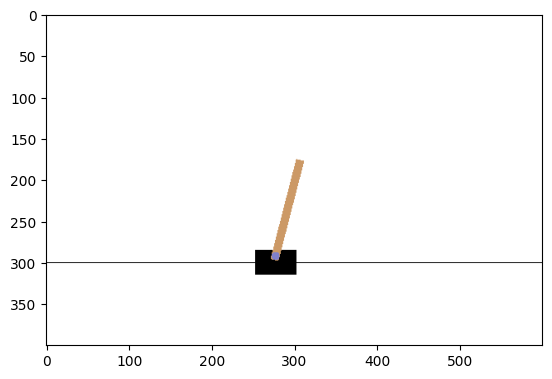

In [ ]:
env = gym.make(ENV)
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)
plt.show()

steps = 50

for _ in range(steps):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    screen = env.render(mode = 'rgb_array')

    plt.imshow(screen)
    # wait = True waits to clear the output until new output is available to replace it
    ipythondisplay.clear_output(wait = True)
    # gcf() gets the current figure
    ipythondisplay.display(plt.gcf())
 
    if done:
        break

ipythondisplay.clear_output(wait = True)
env.close()

In [ ]:
## video of random sampling

fps = 30
steps = 200

# get_writer returns a Writer object which can be used to write data and meta data to specified file
with imageio.get_writer(VIDEO_DIR_01, fps = fps) as video:
    for _ in range(steps):
        state = env.reset()
        done = False

        screen = env.render(mode = 'rgb_array')
        # append_data appends an image (and meta data) to the file
        video.append_data(screen)

        while not done:
            action = env.action_space.sample()
            next_state, reward, done, info = env.step(action)
            screen = env.render(mode = 'rgb_array')
            video.append_data(screen)
            state = next_state

In [ ]:
## global network

class ActorCriticModel(keras.Model):
    def __init__(self, state_size, action_size):
        # subclassing the Model class https://www.tensorflow.org/api_docs/python/tf/keras/Model
        # define layers in __init__ and implement forward pass in call
        super(ActorCriticModel, self).__init__()
        self.state_size = state_size
        self.aciton_size = action_size
        self.dense1 = layers.Dense(100, activation = 'relu')
        self.policy_logits = layers.Dense(action_size)
        self.dense2 = layers.Dense(100, activation = 'relu')
        self.values = layers.Dense(1)

    def call(self, inputs):
        # forward pass
        # policy probability logits, which will be probability later by tf.nn.softmax
        x = self.dense1(inputs)
        logits = self.policy_logits(x)
        # values
        v1 = self.dense2(inputs)
        values = self.values(v1)
        return logits, values

In [ ]:
## helper function

def record(episode,
           episode_reward,
           worker_idx,
           global_ep_reward,
           result_queue,
           total_loss,
           num_steps):
    """Helper function to store scores and print statistics.

    Arguments:
      episode: Current episode
      episode_reward: Reward accumulated over the current episode
      # ?
      worker_idx: Which thread (worker)
      # ?
      global_ep_reward: The moving average of the global reward
      result_queue: Queue storing the moving average of the scores
      total_loss: The total loss accumulated over the current episode
      num_steps: The number of steps the episode took to complete
    """
    # ?
    if global_ep_reward == 0:
        global_ep_reward = episode_reward
    else:
        # what is this equation?
        global_ep_reward = global_ep_reward * 0.99 + episode_reward * 0.01
    # https://realpython.com/python-f-strings/
    print(
        f"Episode: {episode} | "
        f"Moving Average Reward: {int(global_ep_reward)} | "
        f"Episode Reward: {int(episode_reward)} | "
        f"Loss: {int(total_loss / float(num_steps) * 1000) / 1000} | "
        f"Steps: {num_steps} | "
        f"Worker: {worker_idx}"
    )
    result_queue.put(global_ep_reward)
    return global_ep_reward

In [ ]:
## random agent

class RandomAgent:
    """Agent playing randomly
    Arguments:
      env_name: Name of the environment
      max_eps: Maximum number of episodes
    """
    def __init__(self, env_name, max_eps):
        self.env = gym.make(env_name)
        self.max_episodes = max_eps
        self.global_moving_average_reward = 0
        # ?
        self.res_queue = Queue()

    def run(self):
        # initialize
        reward_avg = 0
        for episode in range(self.max_episodes):
            # initialize
            done = False
            self.env.reset()
            reward_sum = 0.0
            steps = 0
            # initially, not False = True
            while not done:
                # sample actions randomly
                # random agent does not care so having underscores
                _, reward, done, _ = self.env.step(self.env.action_space.sample())
                steps += 1
                # reward_sum is sum of rewards in each episode
                reward_sum += reward
                # record statistics
                # ?
            self.global_moving_average_reward = record(episode,
                                                       reward_sum,
                                                       0, 
                                                       self.global_moving_average_reward,
                                                       self.res_queue,
                                                       0,
                                                       steps)
            reward_avg += reward_sum
        final_avg = reward_avg / float(self.max_episodes)
        print("Average score across {} episodes: {}".format(self.max_episodes, final_avg))
        return final_avg

In [ ]:
## run random agent

# agent = RandomAgent(ENV, 4000)
# final_avg = agent.run()
# print('final_avg', final_avg)

In [ ]:
## master agent

class MasterAgent():
    """This agent instantiates the global network that
    each worker agent will update as well as the optimizer that
    we will use to update it.
    This master agent holds a shared optimizer that
    updates its global network.
    """
    def __init__(self):
        self.game_name = ENV
        save_dir = args.save_dir
        self.save_dir = save_dir
        # it will automatically make directory
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        env = gym.make(self.game_name)
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        # args.lr? use_locking = True?
        # self.opt = tf.train.AdamOptimizer(args.lr, use_locking = True)
        self.opt = tf.compat.v1.train.AdamOptimizer(args.lr, use_locking = True)
        print(self.state_size, self.action_size)

        # global network
        self.global_model = ActorCriticModel(self.state_size, self.action_size)
        # np.random.random returns [0.0, 1.0)
        self.global_model(tf.convert_to_tensor(np.random.random((1, self.state_size)), 
                                               dtype = tf.float32))
        
    def train(self):
        """Instantiate and start each of the agents
        """
        if args.algorithm == 'random':
            random_agent = RandomAgent(self.game_name, args.max_eps)
            random_agent.run()
            return

        # what is this for?
        res_queue = Queue()

        # ?
        workers = [Worker(self.state_size,
                          self.action_size,
                          self.global_model,
                          self.opt,
                          res_queue,
                          i,
                          game_name = self.game_name,
                          save_dir = self.save_dir) for i in range(multiprocessing.cpu_count())]

        for i, worker in enumerate(workers):
            print("Starting worker {}".format(i))
            worker.start()

        # record episode reward to plot
        moving_average_rewards = []
        while True:
            reward = res_queue.get()
            if reward is not None:
                moving_average_rewards.append(reward)
            else:
                break
        [w.join() for w in workers]

        plt.plot(moving_average_rewards)
        plt.ylabel('Moving average ep reward')
        plt.xlabel('Step')
        plt.savefig(os.path.join(self.save_dir,
                                 '{} Moving Average.png'.format(self.game_name)))
        plt.show()

    def play(self):
        env = gym.make(self.game_name).unwrapped
        state = env.reset()
        model = self.global_model
        model_path = os.path.join(self.save_dir,
                                  'model_{}.h5'.format(self.game_name))
        # model_path = os.path.join(self.save_dir,
        #                           'model_{}.h5'.format('CartPole-v0'))
        print('Loading model from: {}'.format(model_path))
        model.load_weights(model_path)
        done = False
        step_counter = 0
        reward_sum = 0

        try:
            while not done:
                # env.render seems to not work in Google Colab
                # env.render(mode = 'rgb_array')
                policy, value = model(tf.convert_to_tensor(state[None, :],
                                                           dtype = tf.float32))
                policy = tf.nn.softmax(policy)
                action = np.argmax(policy)
                state, reward, done, _ = env.step(action)
                reward_sum += reward
                print("{}. Reward: {}, action: {}".format(step_counter, reward_sum, action))
                step_counter += 1
        except KeyboardInterrupt:
            print("Received Keyboard Interrupt. Shutting down.")
        finally:
            env.close()

In [ ]:
## memory class

class Memory:
    """Keep track of actions, rewards, states
    """
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []

    def store(self, state, action, reward):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)

    def clear(self):
        self.states = []
        self.actions = []
        self.rewards = []

In [ ]:
## worker agent

class Worker(threading.Thread):
    """Worker agent
    """
    # Set up global variables across different threads
    global_episode = 0
    # Movin average reward
    global_moving_average_reward = 0
    best_score = 0
    save_lock = threading.Lock()

    def __init__(self,
                 state_size,
                 action_size,
                 global_model,
                 opt,
                 result_queue,
                 idx,
                 game_name = ENV,
                 save_dir = '/tmp'):
        super(Worker, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.result_queue = result_queue
        self.global_model = global_model
        self.opt = opt
        self.local_model = ActorCriticModel(self.state_size,
                                            self.action_size)
        self.worker_idx = idx
        self.game_name = game_name
        self.env = gym.make(self.game_name).unwrapped
        self.save_dir = save_dir
        self.ep_loss = 0.0

    def run(self):
        """The agent acts according to policy function as the actor,
        while the action is judged by the critic, which is value function
        1. get policy (action probability distribution) from current frame
        2. Step by action chosen from the policy
        3. if the agent has taken a certain number of steps (args.update_freq),
           or the agent has reached a terminal state,
           then update the global model with gradients computed from local model
        4. repeat.
        """
        total_step = 1
        mem = Memory()
        while Worker.global_episode < args.max_eps:
            current_state = self.env.reset()
            mem.clear()
            ep_reward = 0.
            ep_steps = 0
            self.ep_loss = 0

            time_count = 0
            done = False
            while not done:
                logits, _ = self.local_model(
                    tf.convert_to_tensor(current_state[None, :],
                                         dtype = tf.float32))
                probs = tf.nn.softmax(logits)
                action = np.random.choice(self.action_size, p = probs.numpy()[0])
                new_state, reward, done, _ = self.env.step(action)
                # ?
                if done:
                    reward = -1
                ep_reward += reward
                mem.store(current_state, action, reward)

                if time_count == args.update_freq or done:
                    # Calculate gradient with respect to local model.
                    # Do so by tracking the variables involved in computing the loss
                    # by using tf.GraddientTape
                    with tf.GradientTape() as tape:
                        total_loss = self.compute_loss(done,
                                                       new_state,
                                                       mem,
                                                       args.gamma)
                    self.ep_loss += total_loss
                    # Calculate local gradients
                    grads = tape.gradient(total_loss, 
                                          self.local_model.trainable_weights)
                    # Push local gradients to global model
                    self.opt.apply_gradients(zip(grads,
                                                 self.global_model.trainable_weights))
                    # Update local model with new weights
                    self.local_model.set_weights(self.global_model.get_weights())

                    mem.clear()
                    time_count = 0

                    # done and print information
                    if done:
                        # use helper function
                        Worker.global_moving_average_reward = record(Worker.global_episode,
                                                                     ep_reward, 
                                                                     self.worker_idx,
                                                                     Worker.global_moving_average_reward,
                                                                     self.result_queue,
                                                                     self.ep_loss,
                                                                     ep_steps)
                        # use a lock to save model and to print to prevent data races.
                        if ep_reward > Worker.best_score:
                            with Worker.save_lock:
                                print("Saving best model to {}, episode score: {}".format(self.save_dir, ep_reward))
                                self.global_model.save_weights(os.path.join(self.save_dir,
                                                                            'model_{}.h5'.format(self.game_name)))
                                Worker.best_score = ep_reward
                        Worker.global_episode += 1
                ep_steps += 1
                
                time_count += 1
                current_state = new_state
                total_step += 1
        self.result_queue.put(None)

    def compute_loss(self,
                     done,
                     new_state,
                     memory,
                     gamma = 0.99):
        # terminal
        if done:
            reward_sum = 0.
        else:
            reward_sum = self.local_model(tf.convert_to_tensor(new_state[None, :],
                                                               dtype = tf.float32))[-1].numpy()[0]
        # get discounted rewards
        discounted_rewards = []
        # reverse buffer r?
        for reward in memory.rewards[::-1]:
            reward_sum = reward + gamma * reward_sum
            discounted_rewards.append(reward_sum)
        discounted_rewards.reverse()

        logits, values = self.local_model(tf.convert_to_tensor(np.vstack(memory.states),
                                                               dtype = tf.float32))

        # get out advantages
        advantage = tf.convert_to_tensor(np.array(discounted_rewards)[:, None], dtype = tf.float32) - values

        # value loss
        value_loss = advantage ** 2

        # calculate policy loss
        policy = tf.nn.softmax(logits)
        entropy = tf.nn.softmax_cross_entropy_with_logits(labels = policy, logits = logits)

        policy_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = memory.actions, logits = logits)

        # what is 1e-20?
        # entropy = tf.reduce_sum(policy * tf.log(policy + 1e-20), axis = 1)
        # actions_one_hot = tf.one_hot(
        #     memory.actions,
        #     self.action_size,
        #     dtype = tf.float32
        # )
        # policy_loss = tf.nn.softmax_cross_entropy_with_logits_v2(
        #     labels = actions_one_hot,
        #     logits = logits
        # )

        policy_loss *= tf.stop_gradient(advantage)
        policy_loss -= 0.01 * entropy
        total_loss = tf.reduce_mean((0.5 * value_loss + policy_loss))
        return total_loss

4 2
Starting worker 0
Starting worker 1
Episode: 0 | Moving Average Reward: 15 | Episode Reward: 15 | Loss: 2.409 | Steps: 16 | Worker: 1
Saving best model to /tmp/, episode score: 15.0
Episode: 1 | Moving Average Reward: 15 | Episode Reward: 26 | Loss: 2.963 | Steps: 27 | Worker: 0
Saving best model to /tmp/, episode score: 26.0
Episode: 2 | Moving Average Reward: 15 | Episode Reward: 29 | Loss: 2.889 | Steps: 30 | Worker: 1
Saving best model to /tmp/, episode score: 29.0
Episode: 3 | Moving Average Reward: 15 | Episode Reward: 10 | Loss: 1.642 | Steps: 11 | Worker: 0
Episode: 4 | Moving Average Reward: 15 | Episode Reward: 12 | Loss: 1.95 | Steps: 13 | Worker: 0Episode: 4 | Moving Average Reward: 15 | Episode Reward: 12 | Loss: 1.923 | Steps: 13 | Worker: 1

Episode: 6 | Moving Average Reward: 15 | Episode Reward: 18 | Loss: 2.724 | Steps: 19 | Worker: 1
Episode: 7 | Moving Average Reward: 15 | Episode Reward: 20 | Loss: 3.569 | Steps: 21 | Worker: 0
Episode: 8 | Moving Average Rewar

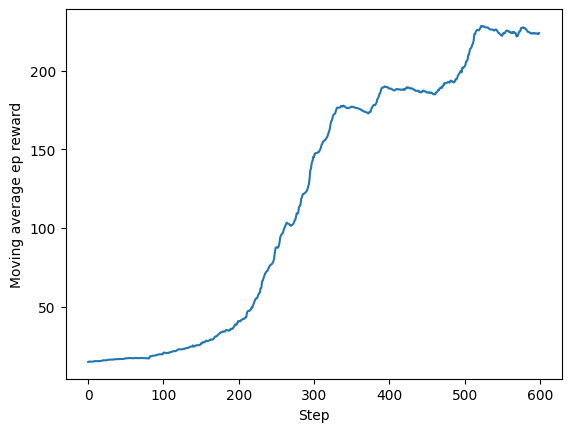

In [ ]:
## training

args = Argument()
master = MasterAgent()
master.train()

In [ ]:
## testing the algorithm

# master = MasterAgent()
# master.play()

In [ ]:
## evaluation video

MODEL_DIR = '/tmp/model_CartPole-v0.h5'
fps = 30

# initialize
# print(gym.make(ENV))
env = gym.make(ENV).unwrapped
# print(env)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
model = ActorCriticModel(state_size, action_size)
# why do we need below
model(tf.convert_to_tensor(np.random.random((1, state_size)),
                           dtype = tf.float32))
model_path = MODEL_DIR
print('Loading model from: {}'.format(model_path))
model.load_weights(model_path)

with imageio.get_writer(VIDEO_DIR_02, fps = fps) as video:
    state = env.reset()
    # print(state, state.shape)
    # print(state[None, :], state[None, :].shape)
    done = False
    screen = env.render(mode = 'rgb_array')
    video.append_data(screen)

    while not done:
        # state[None, :] makes original (4,) shape to (1, 4) shape
        policy, value = model(tf.convert_to_tensor(state[None, :], dtype = tf.float32))
        policy = tf.nn.softmax(policy)
        action = np.argmax(policy)
        next_state, reward, done, info = env.step(action)
        screen = env.render(mode = 'rgb_array')
        video.append_data(screen)
        state = next_state

env.close()

Loading model from: /tmp/model_CartPole-v0.h5


In [ ]:
## log

# 4 2
# Starting worker 0
# Starting worker 1
# Exception in thread Thread-10:
# Traceback (most recent call last):
#   File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
#     self.run()
#   File "<ipython-input-64-de12702797f5>", line 78, in run
#     args.gamma)
#   File "<ipython-input-64-de12702797f5>", line 150, in compute_loss
#     dtype = tf.float32 - values
#   File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py", line 1155, in r_binary_op_wrapper
#     x = ops.convert_to_tensor(x, dtype=y.dtype.base_dtype, name="x")
#   File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 1499, in convert_to_tensor
#     ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
#   File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/constant_op.py", line 338, in _constant_tensor_conversion_function
#     return constant(v, dtype=dtype, name=name)
#   File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/constant_op.py", line 264, in constant
#     allow_broadcast=True)
#   File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/constant_op.py", line 275, in _constant_impl
#     return _constant_eager_impl(ctx, value, dtype, shape, verify_shape)
#   File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/constant_op.py", line 300, in _constant_eager_impl
#     t = convert_to_eager_tensor(value, ctx, dtype)
#   File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/constant_op.py", line 98, in convert_to_eager_tensor
#     return ops.EagerTensor(value, ctx.device_name, dtype)
# ValueError: Attempt to convert a value (tf.float32) with an unsupported type (<class 'tensorflow.python.framework.dtypes.DType'>) to a Tensor.

# Exception in thread Thread-11:
# Traceback (most recent call last):
#   File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
#     self.run()
#   File "<ipython-input-64-de12702797f5>", line 78, in run
#     args.gamma)
#   File "<ipython-input-64-de12702797f5>", line 150, in compute_loss
#     dtype = tf.float32 - values
#   File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py", line 1155, in r_binary_op_wrapper
#     x = ops.convert_to_tensor(x, dtype=y.dtype.base_dtype, name="x")
#   File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 1499, in convert_to_tensor
#     ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
#   File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/constant_op.py", line 338, in _constant_tensor_conversion_function
#     return constant(v, dtype=dtype, name=name)
#   File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/constant_op.py", line 264, in constant
#     allow_broadcast=True)
#   File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/constant_op.py", line 275, in _constant_impl
#     return _constant_eager_impl(ctx, value, dtype, shape, verify_shape)
#   File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/constant_op.py", line 300, in _constant_eager_impl
#     t = convert_to_eager_tensor(value, ctx, dtype)
#   File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/constant_op.py", line 98, in convert_to_eager_tensor
#     return ops.EagerTensor(value, ctx.device_name, dtype)
# ValueError: Attempt to convert a value (tf.float32) with an unsupported type (<class 'tensorflow.python.framework.dtypes.DType'>) to a Tensor.